In [1]:
from modelos.modelos import comunio_pred_lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

C:\Users\botic\anaconda3\envs\comunio_ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Primero obtenemos los datos para entrenar los modelos

    Para ello utilizo las funciones en el archivo comunio_pred_lib.
    - create_data_train genera un data frame por cada jornada que reciba como argumento
    - preprocess_data recibe el data frame resultante de la operación de antes y nos genera
      las variables necesarias para entrenar nuestros modelos.
          - X: Datos numéricos de nuestro data frame inicial sin el target
          - y: Target que recibirá nuestro modelo
          - X_train, X_test, y_train, y_test : Datos resultantes de realizar la operación train_test_split
          - X_train_s, X_test_s, y_train_s, y_test_s: Datos anteriores normalizados
          - x_scaler, y_scaler: Variable necesaria para poder transformar los datos en el futuro

In [ ]:
# List of journeys to create a full data frame to train de models

j = [19,20,21,23,25,26,27,28,29,30,31,32,33,34,35]

df = pd.DataFrame()
for journey in j:
    print('Añadiendo Jornada',journey)
    if journey != 21 and journey != 23:
        
        df_2 = comunio_pred_lib.create_data_train(journey)

        n_j = journey+1
        
        next_j = comunio_pred_lib.create_data_train(n_j)
        next_j = next_j[['Player','J_Actual']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_Actual':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()
            
        
    
    else:
        
        df_2 = comunio_pred_lib.create_data_train(journey)
        n_j = journey+2
        
        next_j = comunio_pred_lib.create_data_train(n_j)
        next_j = next_j[['Player','J_1']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_1':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()

    df = df.append(df_3)


In [ ]:
X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler = comunio_pred_lib.preprocess_data(df)

In [ ]:
rfr = RandomForestRegressor(max_depth= 5, max_leaf_nodes= 35, n_estimators= 300, n_jobs= -1)
xgbr = XGBRegressor(max_depth=5, n_estimators=500,learning_rate=0.01, n_jobs=-1, gamma=0.1 )
gb = GradientBoostingRegressor(max_depth=5, n_estimators=400,learning_rate=0.001, alpha=0.8, max_leaf_nodes=35)
models = (rfr,xgbr,gb)
for model in models:
    name = str(model)[:13]
  
    model.fit(X_train_s,y_train)
    model.score(X_train_s, y_train)
    pred = model.predict(X_test_s)
    mse = mean_squared_error(pred,y_test, squared=False)
    
    
    print (f'mse del modelo {name} = {mse}')

### Reentrenamos los modelos ahora con todos los datos para predecir jornadas venideras

In [ ]:
rfr.fit(X,y)
xgbr.fit(X,y)
gb.fit(X,y)
'Modelos entrenados'

### Se entrenaron dos modelos de redes neuronales con los mismos parámetros salvo las épocas.
    Ejemplo de uno de ellos.
    Se entreno con 10 y 20 epocas
    rnn con 20 epocas y rnn2 con 10 epocas

In [ ]:
rnn =  Sequential()

rnn.add(Dense(500, activation='relu',input_dim=27))
rnn.add(Dense(250, activation='relu'))
rnn.add(Dense(125, activation='relu'))
rnn.add(Dense(60, activation='relu'))
rnn.add(Dense(1, activation='linear'))

rnn.compile(loss="mean_squared_error",
             optimizer="adam")
his = rnn.fit(X_train_s,
        y_train_s,
        epochs=20,
        validation_split=0.2
        )
pred_rnn = rnn.predict(X_test_s)
pred2_rnn = y_scaler.inverse_transform(pred_rnn)
mse = mean_squared_error(pred2_rnn,y_test, squared=False)

        
pd.DataFrame(his.history).plot(figsize=(8,5))
plt.grid()
plt.show()

In [ ]:
print (f'mse del modelo rnn = {mse}')

In [ ]:
import pickle

In [ ]:
pickle.dump(x_scaler,open('modelos/x_scaler.model', 'wb'))
pickle.dump(y_scaler,open('modelos/y_scaler.model', 'wb'))

## Con los modelos ya entrenados realizamos las predicciones

    Vamos utilizar los datos de la jornada 33 para predecir la jornada 34

In [2]:
j = comunio_pred_lib.create_data_train(37)
pred_data = j._get_numeric_data()

In [ ]:
j.info()

### Realizamos las predicciones usando las funciones de nuestra librería

    Todas las funciones son similares, reciben un dataframe y devuelven las prediciones de ese df.

In [3]:
pred_rfr = comunio_pred_lib.predict_rf(pred_data)
pred_xgb = comunio_pred_lib.predict_xgb(pred_data)
pred_gb = comunio_pred_lib.predict_gb(pred_data)
pred_rnn = comunio_pred_lib.predict_rnn(pred_data)
pred_rnn2 = comunio_pred_lib.predict_rnn2(pred_data)

C:\Users\botic\anaconda3\envs\comunio_ml\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\botic\anaconda3\envs\comunio_ml\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\botic\anaconda3\envs\comunio_ml\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
 

### Creamos un dataframe con las predicciones de nuestros modelos y añadimos la realidad para comparar

In [4]:
preds = pd.DataFrame(j['Player'])
preds['Position'] = j.Position
preds['Team'] = j.Team
preds['rfr'] = pred_rfr
preds['xgb'] = pred_xgb
preds['gb'] = pred_gb
preds['rnn'] = pred_rnn
preds['rnn2'] = pred_rnn2
#preds = preds.merge(j_34[['Player','J_Actual']], left_on='Player', right_on='Player')
preds = round(preds)
preds['avg_l_5_J'] = j.Avg_last_5_games

preds

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
0,Unai Simón,PT,Athletic Club,3.0,3.0,3.0,3.0,3.0,4.4
1,Agirrezabala,PT,Athletic Club,1.0,0.0,2.0,0.0,1.0,0.8
2,Ezkieta,PT,Athletic Club,0.0,0.0,2.0,0.0,1.0,0.0
3,Iñigo Martínez,DF,Athletic Club,4.0,4.0,3.0,3.0,4.0,4.4
4,Daniel Vivian,DF,Athletic Club,3.0,2.0,3.0,1.0,3.0,2.0
5,Yeray Álvarez,DF,Athletic Club,3.0,3.0,2.0,2.0,3.0,4.2
6,De Marcos,DF,Athletic Club,3.0,3.0,2.0,2.0,3.0,2.8
7,Lekue,DF,Athletic Club,1.0,1.0,2.0,1.0,2.0,0.8
8,Balenziaga,DF,Athletic Club,1.0,1.0,2.0,1.0,2.0,0.4
9,Yuri Berchiche,DF,Athletic Club,4.0,3.0,3.0,3.0,4.0,4.8


### Ahora vamos a explorar un poco los resultados y obtener los 11 ideales para la J 34

    Para utilizamos las funciones de once_ideal_(modelo) para obtener el once ideal previsto por ese modelo.
    Disponemos de 5 funciones:            
    
    Cada función recibe unos datos y la disposición de la alineación, numero de defensas, medios atacantes.
    
        - once_ideal_rf (Usa el modelo random forest)
        - once_ideal_xgb (Usa el modelo xgboot)
        - once_ideal_gb (Usa el modelo gradient boost)
        - once_ideal_rnn (Usa el modelo red neuronal con 20 épocas)
        - once_ideal_rnn2 (Usa el modelo red neuronal con 10 épocas)

### Distribución de los puntos de todos los jugadores en la J 34

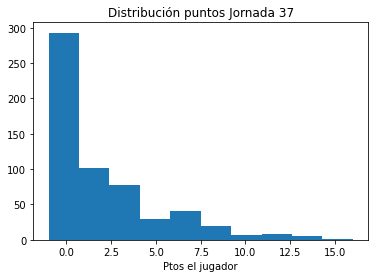

In [5]:
plt.hist(j['J_Actual'], bins=10);
plt.title('Distribución puntos Jornada 37')
plt.xlabel('Ptos el jugador');

#### Distribución de las predicciones de cada uno de los modelos

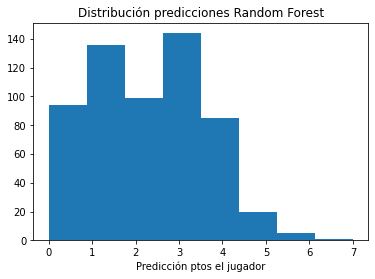

In [6]:
plt.hist(round(preds.rfr), bins=8);
plt.title('Distribución predicciones Random Forest')
plt.xlabel('Predicción ptos el jugador');

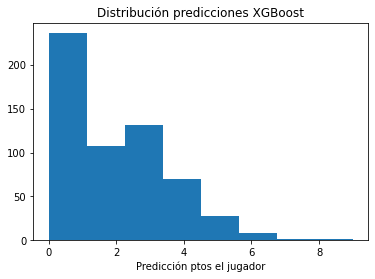

In [7]:
plt.hist(round(preds.xgb), bins=8);
plt.title('Distribución predicciones XGBoost')
plt.xlabel('Predicción ptos el jugador');

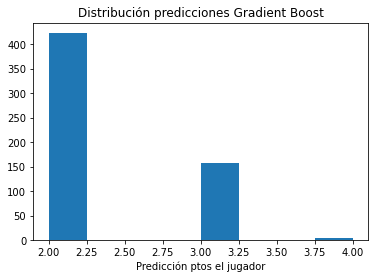

In [8]:
plt.hist(round(preds.gb), bins=8);
plt.title('Distribución predicciones Gradient Boost')
plt.xlabel('Predicción ptos el jugador');

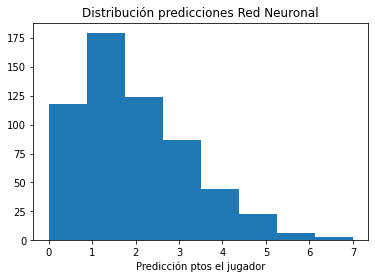

In [9]:
plt.hist(round(preds.rnn), bins=8);
plt.title('Distribución predicciones Red Neuronal')
plt.xlabel('Predicción ptos el jugador');


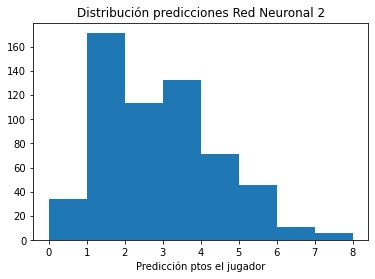

In [10]:
plt.hist(round(preds.rnn2), bins=8);
plt.title('Distribución predicciones Red Neuronal 2')
plt.xlabel('Predicción ptos el jugador');

### Generamos los onces ideales de cada equipo y comparamos la predicción con los datos reales

In [11]:
eleven_rf = comunio_pred_lib.once_ideal_rf(preds,3,4,3)
eleven_xgb = comunio_pred_lib.once_ideal_xbgr(preds,3,4,3)
eleven_gb = comunio_pred_lib.once_ideal_gb(preds,3,4,3)
eleven_rnn = comunio_pred_lib.once_ideal_rnn(preds,3,4,3)
eleven_rnn2 = comunio_pred_lib.once_ideal_rnn2(preds,3,4,3)

C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(po

In [13]:
print('Totales xgb: ', sum(eleven_xgb.xgb), ', real: ', 
      #sum(eleven_xgb.J_Actual)
     )
print('Totales rfr: ', sum(eleven_rf.rfr), ', real: ', 
      #sum(eleven_rf.J_Actual)
     )
print('Totales gb: ', sum(eleven_gb.gb), ', real: ', 
      #sum(eleven_gb.J_Actual)
     )
print('Totales rnn: ', sum(eleven_rnn.rnn), ', real: ', 
      #sum(eleven_rnn.J_Actual)
     )
print('Totales rnn2: ', sum(eleven_rnn2.rnn2), ', real: ', 
      #sum(eleven_rnn2.J_Actual)
     )

Totales xgb:  65.0 , real: 
Totales rfr:  60.0 , real: 
Totales gb:  37.0 , real: 
Totales rnn:  62.0 , real: 
Totales rnn2:  69.0 , real: 


In [14]:
eleven_gb

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
471,Jeremías Ledesma,PT,Cádiz,4.0,4.0,3.0,2.0,4.0,6.4
389,Alfonso Pedraza,DF,Villarreal,5.0,6.0,4.0,3.0,4.0,7.0
109,Jordi Alba,DF,Barcelona,5.0,5.0,3.0,6.0,6.0,7.6
259,Óscar Duarte,DF,Levante,3.0,4.0,3.0,3.0,4.0,7.0
366,Silva,MD,Real Sociedad,4.0,5.0,3.0,4.0,5.0,8.6
333,Canales,MD,Betis,6.0,5.0,3.0,5.0,6.0,8.4
398,Parejo,MD,Villarreal,5.0,5.0,3.0,5.0,5.0,8.0
536,Denis Suárez,MD,Celta Vigo,4.0,6.0,3.0,5.0,5.0,7.8
548,Iago Aspas,DL,Celta Vigo,6.0,7.0,4.0,7.0,8.0,11.2
222,Benzema,DL,Real Madrid,7.0,7.0,4.0,7.0,8.0,8.6


In [15]:
eleven_rnn2

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
25,Oblak,PT,Atlético Madrid,4.0,5.0,3.0,4.0,5.0,5.2
109,Jordi Alba,DF,Barcelona,5.0,5.0,3.0,6.0,6.0,7.6
558,Kounde,DF,Sevilla,4.0,5.0,3.0,5.0,5.0,6.8
27,José Giménez,DF,Atlético Madrid,4.0,4.0,3.0,5.0,5.0,6.0
333,Canales,MD,Betis,6.0,5.0,3.0,5.0,6.0,8.4
332,Fekir,MD,Betis,6.0,5.0,3.0,5.0,6.0,6.6
214,Kroos,MD,Real Madrid,5.0,5.0,3.0,6.0,6.0,5.6
215,Modric,MD,Real Madrid,5.0,4.0,3.0,5.0,6.0,5.2
548,Iago Aspas,DL,Celta Vigo,6.0,7.0,4.0,7.0,8.0,11.2
222,Benzema,DL,Real Madrid,7.0,7.0,4.0,7.0,8.0,8.6


### Ahora vamos a testear con una plantilla real la mía del comunio a ver que alineación recomienda

    Primero generamos un df a partir de los datos de prediciones que tenemos, y los filtramos con los jugadores que tengo en mi plantilla de comunio

In [18]:
squad = ['Courtois', 'Bono',
         'Balliu', 
         'Fran García',
         'Maffeo',
         'Ronald Araujo', 
         'Alderete', 'Manu Sánchez', 
         'Giménez', 
         #'Yéremi',  
         'Gavi',  
         'Modric',  
         'Brais', 'Papu Gómez', 'Dani Rodríguez', 'Pere Milla', 'Cervi', 'Berenguer',
         'Vinícius Júnior', 'Aubameyang', 
         #'Sancet',  
         'Morales']
df_squad_kike = pd.DataFrame()
for player in squad:
    #print (player)
    for p in preds.Player:
        if player in p:
            #print('encontrado')
            add_player = pd.DataFrame(preds.loc[preds.Player==p])
            #print(add_player)
            df_squad_kike = df_squad_kike.append(add_player)
print(len(squad),len(df_squad_kike))

df_squad_kike.at[522,'Position'] = 'MD'
df_squad_kike = round(df_squad_kike)
df_squad_kike

C:\Users\botic\AppData\Local\Temp\ipykernel_8644\1377033949.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_squad_kike = df_squad_kike.append(add_player)
C:\Users\botic\AppData\Local\Temp\ipykernel_8644\1377033949.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_squad_kike = df_squad_kike.append(add_player)
C:\Users\botic\AppData\Local\Temp\ipykernel_8644\1377033949.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_squad_kike = df_squad_kike.append(add_player)
C:\Users\botic\AppData\Local\Temp\ipykernel_8644\1377033949.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_squad_kike = df_squad_kike.append(add_play

20 20


C:\Users\botic\AppData\Local\Temp\ipykernel_8644\1377033949.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_squad_kike = df_squad_kike.append(add_player)


,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
200,Courtois,PT,Real Madrid,4.0,3.0,3.0,3.0,5.0,4.0
554,Bono,PT,Sevilla,4.0,3.0,3.0,4.0,5.0,4.0
237,Balliu,DF,Rayo Vallecano,3.0,3.0,3.0,3.0,3.0,3.0
236,Fran García,DF,Rayo Vallecano,4.0,3.0,3.0,3.0,3.0,3.0
294,Maffeo,DF,Mallorca,4.0,4.0,3.0,3.0,3.0,2.0
110,Ronald Araujo,DF,Barcelona,4.0,5.0,3.0,4.0,5.0,5.0
416,Omar Alderete,DF,Valencia,3.0,3.0,3.0,3.0,3.0,4.0
53,Manu Sánchez,DF,Osasuna,2.0,2.0,2.0,2.0,3.0,2.0
27,José Giménez,DF,Atlético Madrid,4.0,4.0,3.0,5.0,5.0,6.0
121,Gavi,MD,Barcelona,4.0,4.0,3.0,4.0,5.0,4.0


In [19]:
xgb_eleven_kike = round(comunio_pred_lib.once_ideal_xbgr(df_squad_kike,3,4,3))

rf_eleven_kike = round(comunio_pred_lib.once_ideal_rf(df_squad_kike,3,4,3))

gb_eleven_kike = round(comunio_pred_lib.once_ideal_gb(df_squad_kike,3,4,3))

rnn_eleven_kike = round(comunio_pred_lib.once_ideal_rnn(df_squad_kike,3,4,3))

rnn2_eleven_kike = round(comunio_pred_lib.once_ideal_rnn2(df_squad_kike,3,4,3))

print('Totales xgb: ', sum(xgb_eleven_kike.xgb), ', real: ', 
      #sum(xgb_eleven_kike.J_Actual)
     )
print('Totales rfr: ', sum(rf_eleven_kike.rfr), ', real: ', 
      #sum(rf_eleven_kike.J_Actual)
     )
print('Totales gb: ', sum(gb_eleven_kike.gb), ', real: ', 
      #sum(gb_eleven_kike.J_Actual)
     )
print('Totales rnn: ', sum(rnn_eleven_kike.rnn), ', real: ', 
      #sum(rnn_eleven_kike.J_Actual)
     )
print('Totales rnn2: ', sum(rnn2_eleven_kike.rnn2), ', real: ', 
      #sum(rnn2_eleven_kike.J_Actual)
     )

C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:211: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:211: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:211: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:211: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(po

Totales xgb:  51.0 , real: 
Totales rfr:  49.0 , real: 
Totales gb:  34.0 , real: 
Totales rnn:  50.0 , real: 
Totales rnn2:  58.0 , real: 


C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))
C:\Users\botic\Proyectos\Proyecto-Final-Bootcamp\ML\modelos\modelos.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  squad = squad.append(pd.DataFrame(pos))


In [20]:
gb_eleven_kike


,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
200,Courtois,PT,Real Madrid,4.0,3.0,3.0,3.0,5.0,4.0
27,José Giménez,DF,Atlético Madrid,4.0,4.0,3.0,5.0,5.0,6.0
110,Ronald Araujo,DF,Barcelona,4.0,5.0,3.0,4.0,5.0,5.0
416,Omar Alderete,DF,Valencia,3.0,3.0,3.0,3.0,3.0,4.0
539,Franco Cervi,MD,Celta Vigo,3.0,4.0,3.0,3.0,4.0,6.0
215,Modric,MD,Real Madrid,5.0,4.0,3.0,5.0,6.0,5.0
567,Papu Gómez,MD,Sevilla,4.0,5.0,3.0,4.0,5.0,5.0
121,Gavi,MD,Barcelona,4.0,4.0,3.0,4.0,5.0,4.0
223,Vinícius Júnior,DL,Real Madrid,6.0,4.0,4.0,7.0,8.0,7.0
286,Morales,DL,Levante,4.0,4.0,3.0,5.0,5.0,6.0


In [21]:
rnn2_eleven_kike

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
200,Courtois,PT,Real Madrid,4.0,3.0,3.0,3.0,5.0,4.0
27,José Giménez,DF,Atlético Madrid,4.0,4.0,3.0,5.0,5.0,6.0
110,Ronald Araujo,DF,Barcelona,4.0,5.0,3.0,4.0,5.0,5.0
416,Omar Alderete,DF,Valencia,3.0,3.0,3.0,3.0,3.0,4.0
215,Modric,MD,Real Madrid,5.0,4.0,3.0,5.0,6.0,5.0
567,Papu Gómez,MD,Sevilla,4.0,5.0,3.0,4.0,5.0,5.0
121,Gavi,MD,Barcelona,4.0,4.0,3.0,4.0,5.0,4.0
539,Franco Cervi,MD,Celta Vigo,3.0,4.0,3.0,3.0,4.0,6.0
223,Vinícius Júnior,DL,Real Madrid,6.0,4.0,4.0,7.0,8.0,7.0
129,Aubameyang,DL,Barcelona,6.0,9.0,3.0,6.0,7.0,5.0


In [22]:
xgb_eleven_kike

,Player,Position,Team,rfr,xgb,gb,rnn,rnn2,avg_l_5_J
200,Courtois,PT,Real Madrid,4.0,3.0,3.0,3.0,5.0,4.0
110,Ronald Araujo,DF,Barcelona,4.0,5.0,3.0,4.0,5.0,5.0
27,José Giménez,DF,Atlético Madrid,4.0,4.0,3.0,5.0,5.0,6.0
294,Maffeo,DF,Mallorca,4.0,4.0,3.0,3.0,3.0,2.0
567,Papu Gómez,MD,Sevilla,4.0,5.0,3.0,4.0,5.0,5.0
537,Brais Méndez,MD,Celta Vigo,4.0,5.0,3.0,3.0,4.0,3.0
539,Franco Cervi,MD,Celta Vigo,3.0,4.0,3.0,3.0,4.0,6.0
215,Modric,MD,Real Madrid,5.0,4.0,3.0,5.0,6.0,5.0
129,Aubameyang,DL,Barcelona,6.0,9.0,3.0,6.0,7.0,5.0
223,Vinícius Júnior,DL,Real Madrid,6.0,4.0,4.0,7.0,8.0,7.0


## Conclusiones

El peor modelo es sin duda el gradient boost, ya que prácticamente asigna la misma puntución a todos los jugadores.
El resto de modelos funcionan bastante bien y aunque el rnn2 no es el que mejores resultados obtiene en cuanto error absoluto es el que mejor generaliza y se acerca más a la realidad, solo hay que comparar las distribuciones de la puntuación real y de la rnn2 para ver que son las más similares.

In [ ]:
real_madrid = preds.loc[preds.Team=='Real Madrid']
levante = preds.loc[preds.Team=='Betis']

In [ ]:
rnn2_eleven_rm = round(comunio_pred_lib.once_ideal_rnn2(real_madrid,4,3,3))

In [ ]:
rnn2_eleven_rm

In [ ]:
real_madrid

In [ ]:
levante

In [ ]:
rnn2_eleven_lv = round(comunio_pred_lib.once_ideal_rnn2(levante,4,3,3))

In [ ]:
rnn2_eleven_lv

In [ ]:
rnn2_eleven_rm

In [ ]:
'Real Madrid: ', sum(rnn2_eleven_rm.rnn2), 'Betis: ', sum(rnn2_eleven_lv.rnn2)